# Analysis of RNASeq Data from Day 0 
In this notebook, I will be completing RNASeq analysis for the day 0 data. These efforts are part of Aim 1 for my BMEG490B paper, which is: 

<b> Characterizing T-Lineage Restriction of MLPs grown in LEM </b>

In this document, I will be reading in the created ReadCountdata, performing quality control, linking genes to one of three phenotypes of interest (CD45RA-CLEC12A-,CD45RA+CLEC12A- and CLEC12A+). 

## Experimental Workflow 

The experimental workflow generating this data comes from the work of Dr. Fangwu Wang and the Eaves lab, outlined in a paper titled "Human Lymphoid-Neutrophil/Monocyte Restriction Co-ordinately Activates Increased Proliferation Despite Parallel Heterogeneity In Transcriptional Changes". The paper can be found via this link: https://www.biorxiv.org/content/10.1101/2024.02.18.580894v1.full 


The experimental process used to generate the FastQ reads in this file are outlined in Figure 6 of the paper, titled "CD34+RA-C-cells in a lower proliferative state display higher self-renewal transcriptional programs when stimulated to differentiate". 

## Information about the Cells in this Analysis
In this analysis, we will be processing cells obtained at Day 0. Specifically, we are looking at primary cord blood cells that are enriched for CD34+ expression, that were chosen given their strong output in lymphoid progenitors. These cells were dubbed `P-Mix` cells, short for progenitor-mix cells. 

On Day0, a cryopreserved aliquot of these progwas thawed. Cells were then resuspended in PBS supplemented with 1% FBS and 9.1% TruStain FcX. Following a 10-minute incubation, cells were stained with both flow cytometry antibodies and TotalSeq antibodies (BioLegend) as follows: TotalSeq-B0853 anti-human CD371 (CLEC12A), TotalSeq-B0063 anti-human CD45RA, TotalSeq-B0062 anti-human CD10, TotalSeq-B0066 anti-human CD7, TotalSeq-B0054 anti-human CD34, TotalSeq-B0051 anti-human CD14, TotalSeq-B0392 anti-human CD15 (SSEA-1), CD45-AF700 (HI30, BioLegend), CD71-FITC (OKT9, eBioscience), CD38-PECY7 (HIT2, BioLegend), CD45RA-APC (MEM56, Invitrogen), CLEC12A-PE (HB3, eBioscience), CD10-BB700 (MEM78, BD Biosciences) and CD34-BV421 (561, BioLegend).

 Gene expression and surface protein libraries were generated using the Chromium Next GEM Single Cell 3 ’Reagent Kits v3.1 and sequenced by Illumina MiSeq or NextSeq2000. 

## Prior Work Done 

 Prior to the implementation of the analysis in this notebook, the generated BCL files were converted into demultiplexed FASTQ files, which were then processed using Cell Ranger Count v8.0.1 (10x Genomics). Alignment of reads to the human reference genome GRCh38 and calculation of Unique Molecular Identifier (UMI) counts for gene expression and antibody libraries were performed on CellRanger Cloud, and completed using the "Cell Ranger Count" commaand. The UMI counts mapped to each cell were then compiled into a feature-barcode matrix.

 With this context, we can begin our analysis!

 # Step 1: Pre-processing

 In this section, we are going to pre-process the data to create the `SingleCellExperiment` object within the BioConductor analysis pipeline. I will be following the pipeline defined in the free e-book "Orchestrating Single-Cell Analysis" by CellRanger, which may be obtained here: https://bioconductor.org/books/release/OSCA/

 This step will consist of the following phases: 

 1. Analysis of CellRanger Outputs 
 2. Creation of the SingleCellExperriment Object 
 3. Quality Control of scRNASeq Library
 4. Normalization of for Gene Expression
 5. Feature Selection
 
 ## 1.1 - Analysis of CellRanger Outputs

In [1]:
# Analysis of CellRanger Outputs



## 1.2 - Creation of SingleCellExperiment Object

In [2]:
# Creation of SingleCellExperiment Object
library(DropletUtils)
sce <- read10xCounts("data/filteredOutput")
sce


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

class: SingleCellExperiment 
dim: 36608 4731 
metadata(1): Samples
assays(1): counts
rownames(36608): ENSG00000243485 ENSG00000237613 ... TOTALSEQB_CD14
  TOTALSEQB_CD15
rowData names(3): ID Symbol Type
colnames: NULL
colData names(2): Sample Barcode
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

Nice! It looks like I was able to generate the SCE object by pointing to the directory containing the contents of the filtered feature matrix, and have now created a SingleCellExperiment Class object. 

What does this object hold? Simply put, this object class implements a data structure that sttores all aspects of our single-cell data, gene-by-cell expression data, per-cell metadata and per-gene annotation. This allows for us to manipulate them in a synchronized manner. 

Each piece of metadata in the `SingleCellExperiment` class is represented by a "slot". If you imagine the `SingleCellExperiment` object to be a cargo ship, the slots can be thought of as individual cargo boxes with different contents - eg. certain slots expect numeric matrieces whereas other expect dataframes.  

![SCEDescriptor](img\SingleCellExperiment.png)

The `assays` metadata is the most important here, since it contains the primary data such as matrix of sequecing counts, where rows correspond to features (genes), and columns correspond to samples (cells). 

Lets take a look at what's inside the `counts` slot of the  `sce` object we just created

In [3]:
counts(sce)


36608 x 4731 sparse Matrix of class "dgCMatrix"
                                                                                            
ENSG00000243485  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000237613  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000186092  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000238009  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000239945  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000239906  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000241860  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  1  .
ENSG00000241599  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000286448  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000236601  .  . 

Nice! We see that the `assay`  is holding two types of information - the count matrix, and the antibody data, in the form of a spare matrix. This may be confusing, so lets split them into two different slots. 

In [4]:
split_sce <- splitAltExps(sce, rowData(sce)$Type)
split_sce


class: SingleCellExperiment 
dim: 36601 4731 
metadata(1): Samples
assays(1): counts
rownames(36601): ENSG00000243485 ENSG00000237613 ... ENSG00000278817
  ENSG00000277196
rowData names(3): ID Symbol Type
colnames: NULL
colData names(2): Sample Barcode
reducedDimNames(0):
mainExpName: Gene Expression
altExpNames(1): Antibody Capture

Nice! We see that we have seperated the Antibody data into an alternate experiment. We could store this as a seperate assay, or keep it seperated as an alternate experiment!

The last thing I am going to touch on is the metadata of a `SingleCellExperiment`.  To begin, we can further annotate the metadta of the columns of our primary data by using the `colData` slot. This is a `DataFrame` object where rows correspond to cells and columns correspond to metadata fields (e.g. batch of origin, treatment condition, etc.). We can manually access this information with the `colData()` function. 

Simmiliarly, we can store feature level annotation in the `rowData` slot of a `DataFrame`, where each row corresponds to a gene and contains annotations like the transcript length or gene symbol. We can manually get this with the `rowData()` function. 

In [5]:
rowData(split_sce)


DataFrame with 36601 rows and 3 columns
                             ID      Symbol            Type
                    <character> <character>     <character>
ENSG00000243485 ENSG00000243485 MIR1302-2HG Gene Expression
ENSG00000237613 ENSG00000237613     FAM138A Gene Expression
ENSG00000186092 ENSG00000186092       OR4F5 Gene Expression
ENSG00000238009 ENSG00000238009  AL627309.1 Gene Expression
ENSG00000239945 ENSG00000239945  AL627309.3 Gene Expression
...                         ...         ...             ...
ENSG00000277836 ENSG00000277836  AC141272.1 Gene Expression
ENSG00000278633 ENSG00000278633  AC023491.2 Gene Expression
ENSG00000276017 ENSG00000276017  AC007325.1 Gene Expression
ENSG00000278817 ENSG00000278817  AC007325.4 Gene Expression
ENSG00000277196 ENSG00000277196  AC007325.2 Gene Expression

In [6]:
colData(split_sce)


DataFrame with 4731 rows and 2 columns
                  Sample            Barcode
             <character>        <character>
1    data/filteredOutput AAACCCACAGATCACT-1
2    data/filteredOutput AAACCCAGTCCAGCAC-1
3    data/filteredOutput AAACCCAGTGTATACC-1
4    data/filteredOutput AAACCCATCTCTCTAA-1
5    data/filteredOutput AAACGAAAGATCGACG-1
...                  ...                ...
4727 data/filteredOutput TTTGGAGTCGGTGCAC-1
4728 data/filteredOutput TTTGGTTTCACTCACC-1
4729 data/filteredOutput TTTGGTTTCATAGGCT-1
4730 data/filteredOutput TTTGGTTTCCGCGAGT-1
4731 data/filteredOutput TTTGTTGCACACTTAG-1

## 1.3 - Quality Control Steps 

### Motivation for Quality Control 

Low quality libraries in scRNA-seq data can arise form a variety of sources such as cell damage during dissociation or failure in library preperation (ineffecient reverse transcription or PCR Amplification, for example). These artifacts usually manifest as "cells" with low total counts, few expressed genes, or high mitochondrial or spike in proportions. 

These low-quality libraries are problematic, as they can contribute to misleading results in downstream analyses. Some common effects are: 

- The form their own distinct clusters, complicating the interpretation of results. This is mainly driven by the increased mitochondrial proportions or enrichment for nuclear RNAs after cell damage. 
- They interefere with the chaatacterization of population heterogeneity during variance estimation or PCA. Specifically, during dimensionality reduction, the first few steps will end up capturing the difference in quality rather than biology, reducing the effectiveness of dimensionality reduction. Similiarly, genes with the largest variances will be driven by differences between low and high quality cells. 
- They contain genes that appear strongly "upregulated" due to agressive scaling to normalize for small library sizes. This is most problematic for contaminating transcripts (eg, from ambient solution) that are present in all libraries, but at transient levels. 

To avoid/mitigate these issues, we need to remove the problematic cells at the tsrta of the analysis. This step is commonly referred to as quality control (QC) of cells. 

### Common QC Metrics 

Some of the metrics we can use to identify low quality cells are: 

- **The library size:** The library size is defined as the total sum of counts across all relevant features for each cell (a cells total gene count, if you will).  Cells with small library sizes are of low quality, as the RNA has been lost at some point during the libraryr preperation, either due to cell lysis or inefficient cDNA capture. 
- **Number of expressed features:** Defined as the number of endogenous genes with non-0 counts for that cell. Any cell with very few expressed genes is likely to be of poor quality as the diverse transcript population has not been captured. 
- **The proportion of reads mapped to spike-in transcripts:** As the same amount of spike in RNA should have been added to each cell, any enrichment in spike-in count is sumptomatic of loss of endogenous RNA. Therefore, high proportions are indicative of poor quality cells where endogenous RNA has been lost due to partial cell lysis or RNA degradation. 
- **Proportion of reads mapped to mitochondrial genome:** High proportions are indicative of poor quality cells, because of the loss of cytoplasmic RNA from perforated cells. This reasoning is that, in the prosence of modest damage, the holes in the cell memebrane permit efflux of indicidual ttrnascript molecules, but are too small to allow mitochondria to escape, leading to a relative enrichment of mitochondrial transcripts. 

### Implementing QC 

In this analysis, we will calculate the QC metrics using the `perCellQCMetrics()` fucntion fromthe *scater* package. The `sum` column contains the total count for each cell, and the `detected` column contains the number of detected genes. The `subsets_Mito_percent` column contains the percentage of reads mapped to mitochondrial transcripts, and finally the `altexps_ERCC_percent` column contains the percentage of reads mapped to ERCC transcripts. 

Lets begin by identifying the mitochondrial transcripts in our SingleCellExperiment: 

In [7]:
# Identifying mitochondrial transcripts

mito <- grep("^MT-", rowData(split_sce)$Symbol)

library(scuttle)

mito_qc <- perCellQCMetrics(split_sce, subsets = list(Mito = mito))

head(mito_qc)


DataFrame with 6 rows and 9 columns
        sum  detected subsets_Mito_sum subsets_Mito_detected
  <numeric> <integer>        <numeric>             <integer>
1     11666      3554              409                    12
2     10112      3654              295                    11
3     14041      4153              520                    12
4     12291      3475              639                    12
5      9770      3299              299                    12
6     12207      3398              539                    12
  subsets_Mito_percent altexps_Antibody Capture_sum
             <numeric>                    <numeric>
1              3.50591                          903
2              2.91733                         2326
3              3.70344                         1991
4              5.19893                         1284
5              3.06039                         2200
6              4.41550                         1095
  altexps_Antibody Capture_detected altexps_Antibody Capture

Nice! We have obtained a dataframe containing calculations for all of our metrics, from both the antibody and gene ensemble parts of our dataset. Next, lets use this to make a decision on if we will be keeping or rejecting certain genes: 

In [8]:
mito_decisions <- perCellQCFilters(mito_qc, sub.fields = c("subsets_Mito_percent"))

head(mito_decisions)


DataFrame with 6 rows and 4 columns
      low_lib_size   low_n_features high_subsets_Mito_percent   discard
  <outlier.filter> <outlier.filter>          <outlier.filter> <logical>
1            FALSE            FALSE                     FALSE     FALSE
2            FALSE            FALSE                     FALSE     FALSE
3            FALSE            FALSE                     FALSE     FALSE
4            FALSE            FALSE                     FALSE     FALSE
5            FALSE            FALSE                     FALSE     FALSE
6            FALSE            FALSE                     FALSE     FALSE

Nice! Lets see how many cells we will be discarding based on mitochondrial percentage: 

In [9]:
discard.GE <- mito_decisions$discard

sum(discard.GE == TRUE)
sum(discard.GE == FALSE)

# Adding this information to the metadata of SingleCellExperiment Object
colData(split_sce) <- cbind(colData(split_sce), mito_qc)

split_sce$discard.GE <- discard.GE


[1] 384

[1] 4347

From the complete gene set, we see that 384 will be rejected, while 4347 will be retained. Lets take a look at these discarded cells. 

Loading required package: ggplot2



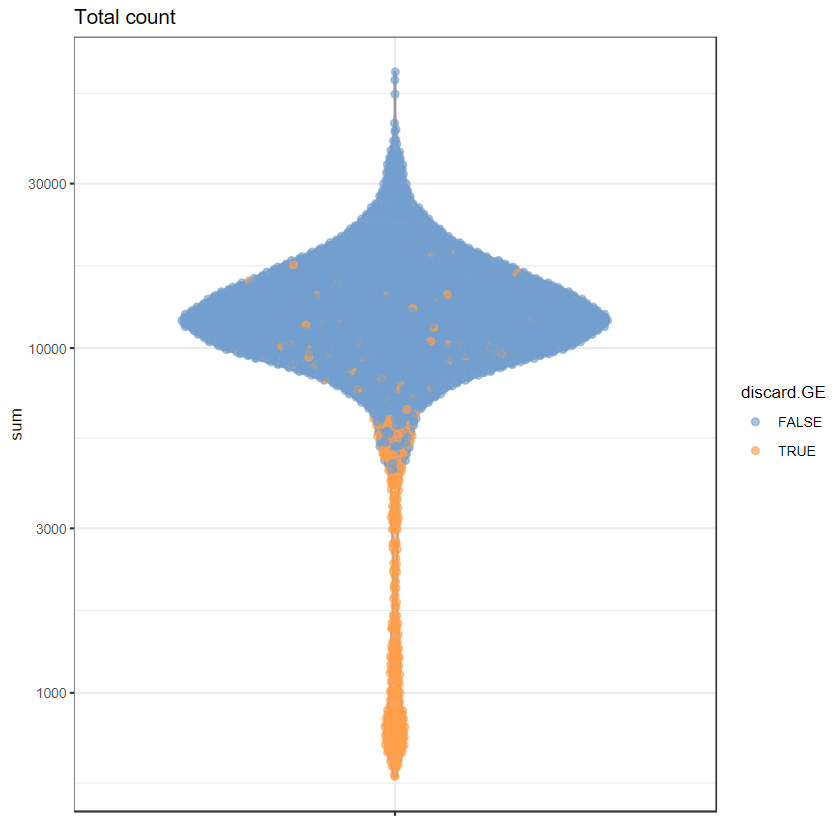

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_ydensity()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


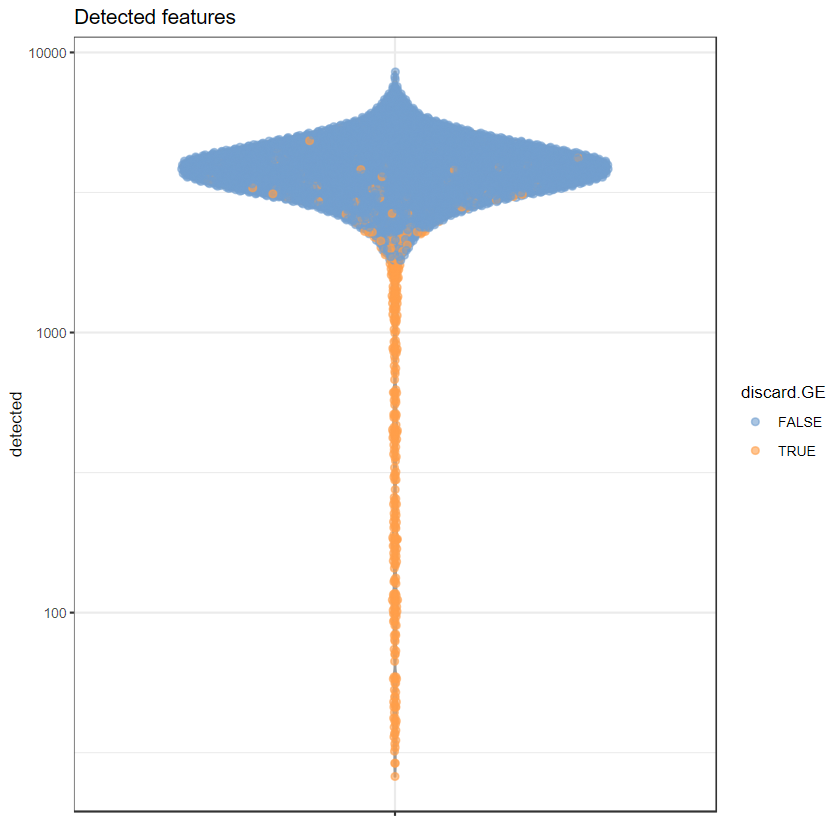

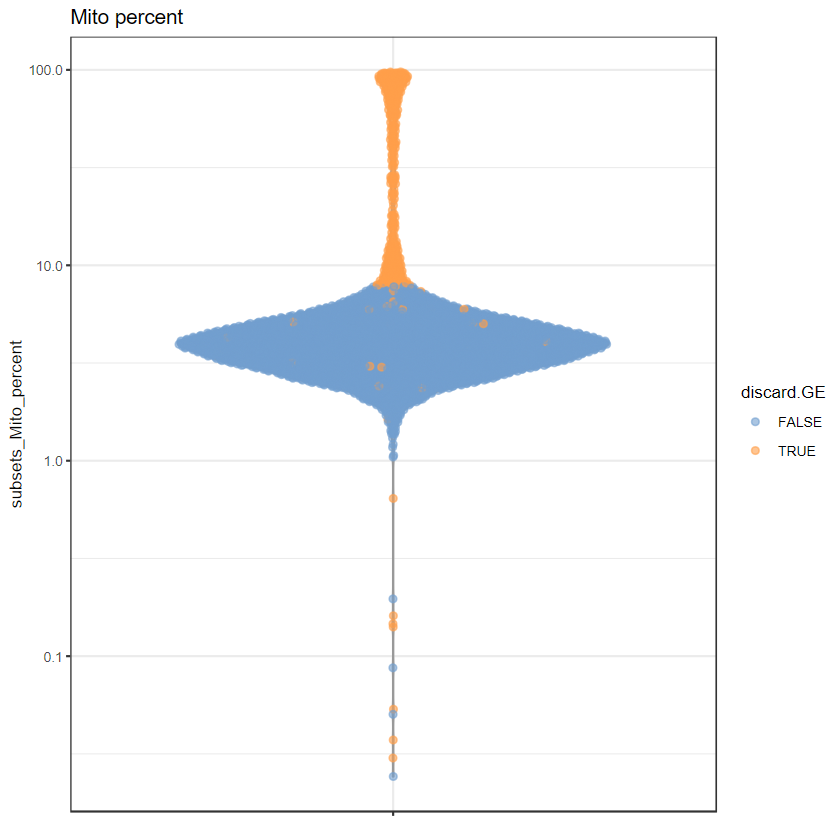

In [10]:
library(scater)

# total UMI
plotColData(split_sce, y = "sum", colour_by = "discard.GE") + scale_y_log10() + ggtitle("Total count") # nolint: line_length_linter.

# detected genes
plotColData(split_sce, y = "detected", colour_by = "discard.GE") + scale_y_log10() + ggtitle("Detected features") # nolint: line_length_linter.

# mito percent
plotColData(split_sce, y = "subsets_Mito_percent", colour_by = "discard.GE") + scale_y_log10() + ggtitle("Mito percent") # nolint: line_length_linter.


It appears that the cells we are discarding are truly outliers. Sanity check passed! Lets continue now onto doing similiar QC for our antibody dataset. 

In [11]:
controls <- grep("^T", rownames(altExp(split_sce)))
antibody_qc <- cleanTagCounts(altExp(split_sce), controls = controls)

print(summary(antibody_qc$zero.ambient))


   Mode   FALSE    TRUE 
logical    4606     125 


Nice! Looks like we will be rejecting 125 samples based on Antibody corruption. Lets label our `SingleCellExperiment` object based on that, and then visualize to see where these cells are found. 

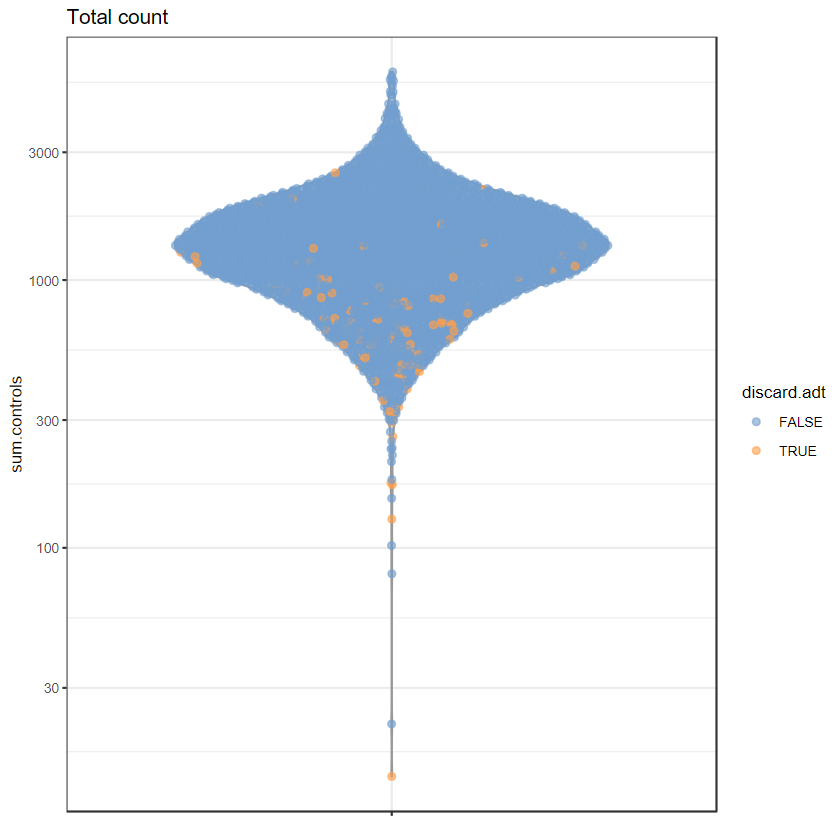

In [12]:
colData(altExp(split_sce)) <- cbind(colData(altExp(split_sce)), antibody_qc)

discard.adt <- antibody_qc$zero.ambient # use zero ambient as the only criteria

altExp(split_sce)$discard.adt <- discard.adt

plotColData(altExp(split_sce), y = "sum.controls", colour_by = "discard.adt") + scale_y_log10() + ggtitle("Total count") # nolint


Okay, it looks like we will be tossing some usefull cells here, but its not the end of the world. Lets now remove all the cells we have marked from the discard dataset, as seen below. 

In [ ]:
discard.all <- discard.adt | discard.GE
qc_sce <- split_sce[, !discard.all]


Nice! We have managed to conduct some QC on our cells, and remove any outliers and bad data from our `SingleCellExperiment` object. We have completed the quality control steps of our analysis, and may move into the next phase. 

## 1.4 - Norallization for Gene Expression

### Motivation for Normalization 

Systematic differences in sequencing coverage between genes are ofteo observed in scRNA sequencing data. They typically arise from technical differences in cDNA or PCR amplification effeciency across cells. Normalization aims to remove these difference such that htey do not interefere with comparisons of the expression profiles between cells. This ensures that any observed heterogeneity or differential expression within the cell population are driven by biology, and not technical biases. 

We will be normalizing the gene expression of our cells by using scaling normalization, which is the simplest and most commonly used class of normalization strategies. This involves dividing all counts for each cell by a cell-specific scaling factor, often called a "size factor". The assumption here is that any cell-specific bias affects all genes equall via scaling of the expected mean count for that cell. The size factor of each cell represents the estimate of the relative bias in that cell, so division of its counts by its size factor remoces that bias. 

The resulting normalized expression values can be used for downstream analysis such as clustering and dimensionality reduction. 

### Normalization by DeConvolution 

Typically, normalization can be performed with the `estimateSizeFactorFromMatrix` function in DeSeq2, or with `calcNormFactors()` in the edgeR package. These assume that most genes are not DE between cells. However, single-cell data cana be problematic for these bulk normalization methods due to the dominance of low and zero counts. To overcome this, we pool counts from many cells to increase the size of the counts for accurate size factor estimation. Pool-based size factors are then deconvolved into cell-based factors for normalization of each cell's expression profile. This is performed using the `calculateSumFactors()` function from scran. 

We will be attempting this below: 

In [ ]:
# BiocManager::install("scran")
library(scran)

set.seed(100)
clust <- quickCluster(qc_sce)
normal_sce <- computeSumFactors(qc_sce, cluster = clust)
normal_sce <- logNormCounts(normal_sce)


Nice! We have normalized our data! Lets move onto the next phase. 

##  1.5 Feature Selection

We often use normalization and dimensionality reduction to characterize heterogeneity across cells. Procedures like clustering and dimesnionality reduction copmare cells based on their gene expression profiles, which involves aggregating per-gene differences into a single (dis)similiarity metric between a pair of cells. The choice of genes to use in this calculation has a major impact on the behavious of the metric, and the performance of downstream methods. We want to select genes that contain useful information about the biology of the sysem, while removing genes that contain random noise. This aims to preserve interesting biological structure without the variance that obscures that structure. 

The simplest approach to doing this is to select the most vaariable genes based on their expression across the population. This assumes that biological differences will manifest as inreased variation in the affected genes, compared to other genes that are only affected by technical noise, or a baseline level of "uninteresting" biological variation. Several methods are available to quantify the variation per gene, and to select "Highly Variable Genes" (HVGS). 

#### Quantifying Per Gene Variation 

We can begin with computing the variance of the log-normalized expression values ("log-counts" for each gene across all cells). The advantage of this approach is that the feature selection is based on the same log-values that are used for later downstream steps. 

In particular, genes with the largest variances in log-values will contribute the most to Euclidean distances between cells during procedures like dimensionality reduction and clustering. 

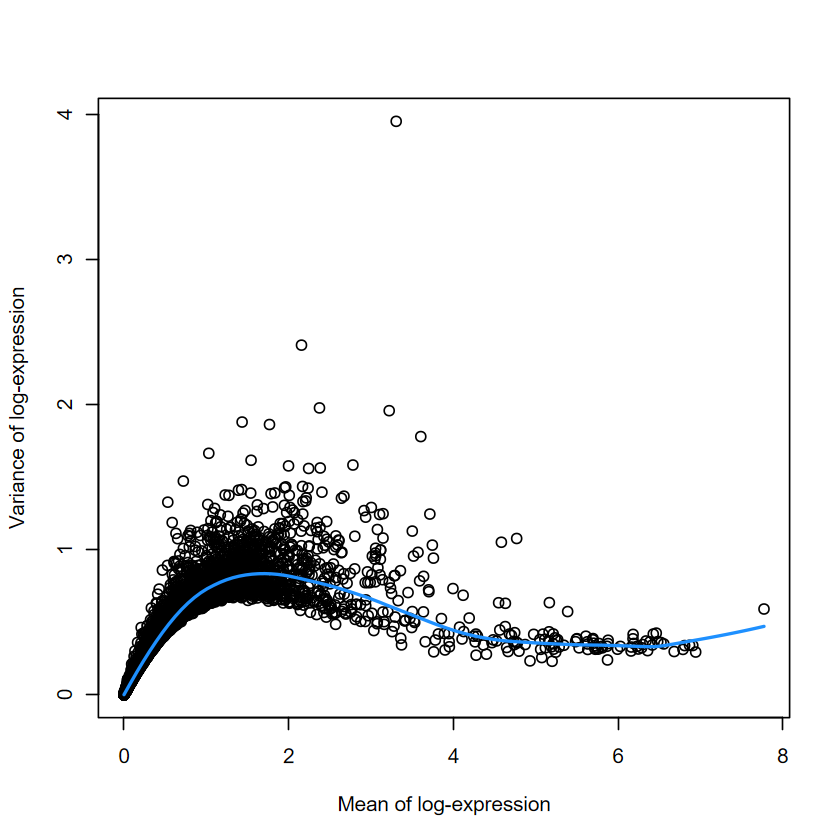

In [ ]:
library(scran)
dec_sce <- modelGeneVar(normal_sce)

# Visualizing the fit:
fit <- metadata(dec_sce)
plot(fit$mean, fit$var,
    xlab = "Mean of log-expression",
    ylab = "Variance of log-expression"
)
curve(fit$trend(x), col = "dodgerblue", add = TRUE, lwd = 2)


Great! We can see that there are quiet a lot of genes away from the mean trend line - this is a good sign. Traditionally, we would visualize what these genes are that are verydifferentially overexpressed/underexpressed from the mean line, but we don't care about that just yet.  

Lets continue our analysis by obtaining the top 20% of differentially expressed genes from our Day 0 Dataset. We will only work with this subset of genes for the rest of the analysis, assuming that the rest is not biologically relevant. 

In [ ]:
rownames(normal_sce) <- rowData(normal_sce)$Symbol # nolint Currently the rownames are ENSEMBL names. Here, I am assigning them to be Gene ENTREZ symbols instead.

hvgs.d0 <- getTopHVGs(normal_sce, prop = 0.2) # nolint: selecting the top 20% of DE genes.



head(hvgs.d0)


[1] "AL589693.1" "RPS4Y1"     "TEX14"      "NKAIN2"     "ATP8B4"    
[6] "AVP"

Nice! It appears that we have a list of top 20% of the genes that were differentially expressed on Day 0, and the count matrix associated with these genes! This concludes our pre-prcoessing steps, and leads us into the next phase of our exploration. 

# Step 2: Defining the General Day 0 Population 

In this section, we will be conducting analysis to transcriptomically define the general Day 0 population, specifically focusing on characterizing the functional actions of our cells, and how they may give clues to their disposition towards a specific cell lineage. To do so, we will conduct the following analysis: 

1. Gene Ontology Analysis  
2. Pathway Enrichment Analysis
3. Cell Type Annotation 

## 2.1 - Gene Ontology Analysis

**Gene Ontology (GO) analysis** is a bioinformatics method used to interpret the biological significance of gene sets by categorizing them into three key domains: **biological processes (BP)** (e.g., cell cycle, apoptosis), **molecular functions (MF)** (e.g., enzyme activity, binding), and **cellular components (CC)** (e.g., nucleus, membrane). By mapping genes to these standardized terms, GO analysis identifies overrepresented or enriched functions, pathways, or cellular locations within a dataset, helping researchers understand the roles of genes in a broader biological context. It is commonly used for analyzing differential expression results or functional characterization of gene clusters.

Using this, we can get a sense for what our Day0 population of HSCs was doing when they were sequenced. 

In [ ]:
# BiocManager::install("org.Hs.eg.db")
# BiocManager::install("clusterProfiler")

library(clusterProfiler)
library(org.Hs.eg.db)
library(AnnotationDbi)
library(tidyverse)

# Running GO
GO_results <- enrichGO(gene = hvgs.d0, OrgDb = "org.Hs.eg.db", keyType = "SYMBOL", ont = "BP") # commented cuz don't want to run over and over

head(as.data.frame(GO_results))


,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0007264,GO:0007264,small GTPase-mediated signal transduction,150/2914,491/18986,0.3054990,1.990461,9.468172,6.071683e-18,3.747442e-14,2.821095e-14,ELMO1/SIPA1L1/VAV3/RAPGEF2/AUTS2/ARHGAP15/MAPRE2/ABCA1/STMN1/CDC42SE2/AKAP13/SQSTM1/RIPOR2/DENND4A/RHOH/ARHGAP32/RAPGEF6/ARHGAP26/DOCK8/DOCK10/RAPGEF1/DOCK4/PREX2/RAP1GAP2/DOCK5/CD2AP/RTN4/SOS1/DENND1A/TNS3/ITGAV/RALGAPA2/MYO9A/PSD3/NF1/CYTH3/TRIO/KSR1/RASA2/DAB1/RASGEF1B/SCAI/ARHGEF40/FAM13A/RAP1A/ARHGAP25/ARHGEF3/CDKN1A/FARP2/ARHGAP10/RASA3/TIAM2/TIAM1/ROBO1/FAM13B/FARP1/DOCK1/ABL1/DOCK2/GBF1/RIN2/RABGEF1/ARFGEF1/OPHN1/CYTH1/MAP4K4/DOCK3/SIPA1L3/ARHGAP21/RALGPS2/NUCB2/PHACTR4/ABR/EPS8/RRAS2/ARHGAP42/PLEKHG1/CCDC88A/SOS2/ARHGAP31/PIK3CB/FGD4/ABL2/SPRY1/HEG1/ARHGEF11/SRGAP3/CTNNAL1/RALGAPA1/ARHGAP5/ABI2/ARHGAP20/ARHGEF12/SHOC2/ITSN1/RRAD/ARHGEF18/CBL/RAP2B/ROCK2/SPATA13/RALGPS1/USP8/PPP2CB/RAPGEF4/RHOB/ARHGAP8/FGD5/RHOBTB1/ARHGAP22/CYTH4/DOCK7/ARHGAP12/RASGRP3/DOCK6/WASF1/RHOC/ARHGAP6/DOCK9/KIF14/CSF1/GARNL3/BCAR3/PLD1/RAPGEF5/RABIF/DOCK11/DOK6/NTN1/RAB33A/ARHGEF7/TAGAP/RERG/ARFGEF3/RABL3/RHOU/RRAS/RASGRP1/GNA12/CDC42EP3/ARHGEF9/PLK2/RAB33B/SH2D3C/SHTN1/DNMBP/RIPOR1/PRAG1/DOK2/SH3BP1,150
GO:0051056,GO:0051056,regulation of small GTPase mediated signal transduction,100/2914,300/18986,0.3333333,2.171814,8.711167,4.817773e-15,1.435345e-11,1.080536e-11,SIPA1L1/VAV3/AUTS2/ARHGAP15/MAPRE2/ABCA1/STMN1/CDC42SE2/AKAP13/SQSTM1/RIPOR2/DENND4A/ARHGAP32/ARHGAP26/DOCK8/DOCK10/PREX2/RAP1GAP2/CD2AP/RTN4/SOS1/DENND1A/TNS3/ITGAV/RALGAPA2/MYO9A/PSD3/NF1/CYTH3/TRIO/RASA2/SCAI/ARHGEF40/FAM13A/ARHGAP25/ARHGEF3/ARHGAP10/RASA3/TIAM2/TIAM1/ROBO1/FAM13B/ABL1/DOCK2/GBF1/RABGEF1/ARFGEF1/OPHN1/CYTH1/MAP4K4/DOCK3/SIPA1L3/ARHGAP21/ABR/EPS8/ARHGAP42/PLEKHG1/SOS2/ARHGAP31/PIK3CB/FGD4/ABL2/SPRY1/HEG1/ARHGEF11/SRGAP3/RALGAPA1/ARHGAP5/ARHGAP20/ARHGEF12/SHOC2/ITSN1/ARHGEF18/CBL/SPATA13/RALGPS1/PPP2CB/ARHGAP8/FGD5/ARHGAP22/CYTH4/DOCK7/ARHGAP12/DOCK6/ARHGAP6/DOCK9/KIF14/CSF1/GARNL3/DOCK11/TAGAP/ARFGEF3/RABL3/RHOU/RASGRP1/ARHGEF9/DNMBP/RIPOR1/PRAG1/SH3BP1,100
GO:0030098,GO:0030098,lymphocyte differentiation,128/2914,426/18986,0.3004695,1.957692,8.512491,6.976726e-15,1.435345e-11,1.080536e-11,HLA-DRA/CD69/TOX/ID2/EGR1/HDAC9/CDK6/HLA-DRB1/RORA/JUNB/ANXA1/CD74/RUNX1/IRF1/ZEB1/KLF6/PBX1/BRAF/SEMA4A/ZFP36L2/MDK/INPP5D/MALT1/ACTB/ZBTB16/SOX4/ARID1B/RHOH/LGALS1/FLT3/FOXP1/IGHM/SH3RF1/DOCK10/FOXO3/IKZF1/PTPRC/SOS1/CTNNB1/RUNX3/ADAM17/BCL2/NFKBIZ/ARID2/ITGA4/STAT4/PLCL2/FNIP1/CARD11/CD83/SMARCA2/SMAD7/SOCS3/PIK3R1/DUSP10/AP3B1/ABL1/TMEM131L/DOCK2/B2M/IL1B/PNP/EGR3/EZH2/TGFBR2/ST3GAL1/RELB/PRDX2/PTK2B/KIT/PTPN22/PIK3R3/XBP1/SOS2/SYK/CBFB/TPD52/TESPA1/RUNX2/NFATC3/NFKBID/PTGER4/PBRM1/IL11/ZFP36L1/IRF8/LEPR/IL18/TGFB1/IL4I1/ZMIZ1/IL15/PIK3CD/GATA3/ZC3H12A/CHD7/FCER1G/IL7/VSIR/ADAM8/PTPN2/TNFSF13B/SOCS1/LAG3/MAFB/MERTK/DOCK11/ITM2A/ENTPD7/RPS6/IL2RG/RABL3/FOSL2/RASGRP1/NRARP/PTPRJ/IL4R/IL18R1/NLRP3/TCF7/LMBR1L/CD79A/DNAJB9/RIPK2/CRACR2A/PRKCZ/PHF14/TRAF3IP2,128
GO:1903706,GO:1903706,regulation of hemopoiesis,127/2914,433/18986,0.2933025,1.910996,8.165230,6.427451e-14,8.283632e-11,6.235964e-11,HLA-DRA/CD69/TOX/ID2/CDK6/HLA-DRB1/JUNB/ANXA1/CD74/RUNX1/IRF1/ZEB1/ZFP36/BRAF/FOS/ZFP36L2/MDK/INPP5D/MEIS1/MALT1/QKI/PPP3CA/ACTB/ZBTB16/SOX4/ARID1B/RHOH/LGALS1/FOXP1/FBXW7/LYN/SH3RF1/KAT6B/NFKBIA/FOXO3/MAPK14/UBASH3B/PTPRC/MEF2C/SOS1/CTNNB1/RUNX3/STAT1/NF1/KAT6A/RHEX/RCOR1/NFKBIZ/ARID2/CARD11/CD83/TSC22D1/KLF13/ZBTB46/HLA-B/SMARCA2/SMAD7/PIK3R1/GATA2/DUSP10/AP3B1/ABL1/TMEM131L/B2M/HSPA1A/PNP/EGR3/PRKCA/TGFBR2/ACVR2A/PRDX2/MYC/PTK2B/CEBPB/PRDM16/XBP1/SOS2/SYK/HMGB2/CBFB/HSPA1B/TESPA1/NFKBID/PBRM1/ZFP36L1/IL18/TGFB1/IL4I1/FBN1/ZMIZ1/IL15/GATA3/ZC3H12A/ROR2/TYROBP/IL7/VSIR/ADAM8/PTPN2/SOCS1/CEBPA/LAG3/MAFB/ISG15/CSF1/PF4/TRIB1/MITF/IL2RG/TMEM64/CDC73/RASGRP1/NRARP/IRF7/IL4R/NLRP3/TCF7/TAL1/GPR137B/CCL3/RASSF2/RIPK2/PRKCZ/JAG1/ETS1/SLC9B2/HOXA5,127
GO:0030217,GO:0030217,T ce

Nice! We know have a dataframe containing the actual cellular processes the top 20% of genes are participating in. Lets visusalize them in a more effecient format using a plot: 

✔ Created directory: results.



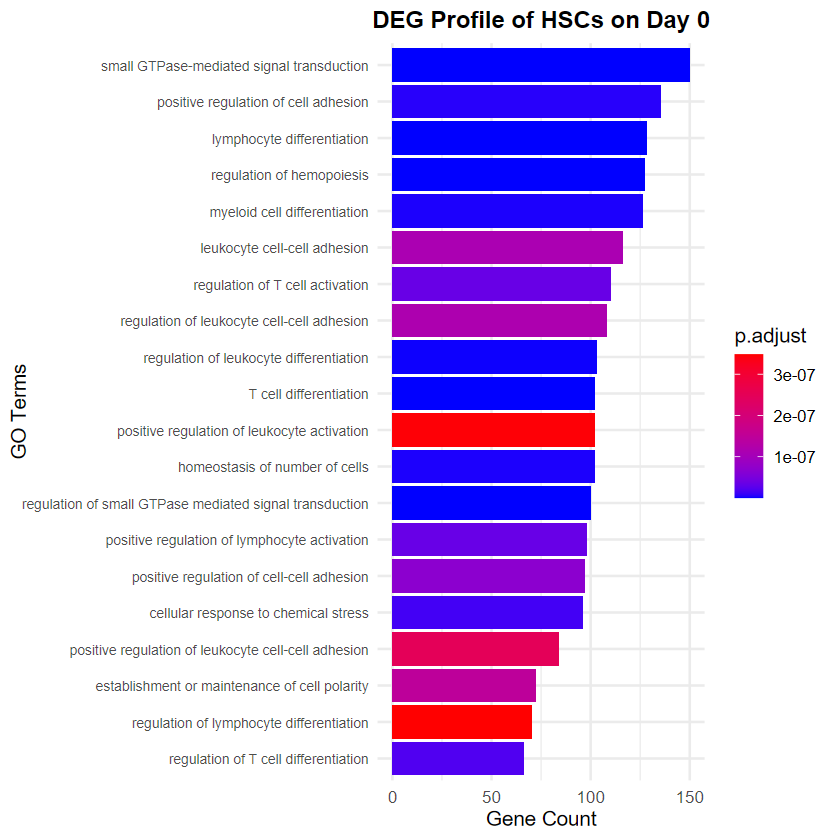

In [ ]:
# Extract the top 20 GO terms
top_GO <- as.data.frame(GO_results) %>%
    arrange(p.adjust) %>%
    slice_head(n = 20)

# Manually create the ggplot
GO_plot <- ggplot(top_GO, aes(x = reorder(Description, Count), y = Count, fill = p.adjust)) +
    geom_bar(stat = "identity") +
    coord_flip() +
    labs(x = "GO Terms", y = "Gene Count", title = "DEG Profile of HSCs on Day 0") +
    theme_minimal(base_size = 12) +
    scale_fill_gradient(low = "blue", high = "red") +
    theme(
        axis.text.x = element_text(size = 10),
        axis.text.y = element_text(size = 8),
        plot.title = element_text(hjust = 0.5, size = 14, face = "bold")
    )

print(GO_plot)

ggsave("results/GO_results.png", plot = GO_plot, width = 10, height = 6, dpi = 300)


This plot effectively characterizes the behavior of your hematopoietic stem cells (HSCs) by highlighting the most significantly enriched Gene Ontology (GO) terms related to differentially expressed genes. By ranking terms by gene count and visualizing the adjusted p-values with a gradient color scale, it provides a clear representation of the key biological processes, such as signal transduction, differentiation, and immune activation, that are driving changes in your HSC population at this specific time point. This allows for intuitive interpretation and prioritization of pathways for further investigation.

## 2.2 Pathway Enrichment Analysis 

**Pathway Enrichment Analysis** is a computational method used to identify biological pathways significantly enriched with a set of genes of interest, such as differentially expressed genes. By mapping genes to predefined pathways (e.g., KEGG, Reactome), it helps uncover underlying biological mechanisms and functional relationships, such as metabolic pathways, signaling cascades, or disease-related processes. This analysis provides a high-level understanding of how gene sets contribute to cellular functions or phenotypes, facilitating the interpretation of complex genomic data.

As a part of our efforts, we will be focusing on two key PEA methods: Kegg and Reactome. 

Reactome and KEGG are two widely used biological databases for pathway enrichment analysis. Both provide curated information about biological pathways but differ in their scope, data sources, and focus areas, making them complementary tools for understanding gene functions and interactions.

| **Aspect**         | **Reactome**                                | **KEGG**                                   |
|---------------------|--------------------------------------------|-------------------------------------------|
| **Focus**          | Broad coverage of molecular pathways, including signaling, metabolic, and disease-specific pathways. | Focuses on metabolic pathways, signaling pathways, and systems biology. |
| **Species**        | Covers multiple species but primarily curated for humans. | Broad species coverage, including humans, bacteria, plants, and more. |
| **Data Source**    | Highly curated from primary literature with detailed annotations. | Integrates data from experiments, literature, and genomic databases. |
| **Visualization**  | Interactive pathway diagrams and tools for in-depth exploration. | Static and network-based visualizations. |
| **Use Cases**      | Ideal for human-focused research or in-depth exploration of signaling pathways. | Excellent for studying metabolic pathways and cross-species comparisons. |

While Reactome excels in human-specific and literature-backed signaling pathways, KEGG is particularly strong in metabolic and cross-species pathway analysis. Together, they provide complementary insights into biological processes, enabling researchers to understand complex gene interactions and functional roles across various contexts.

In [ ]:
entrez_ids <- bitr(
  hvgs.d0,
  fromType = "SYMBOL",
  toType = "ENTREZID",
  OrgDb = org.Hs.eg.db
)

# Use the ENTREZID column
entrez_gene_list <- entrez_ids$ENTREZID

library(clusterProfiler)
library(org.Hs.eg.db) # For human gene annotation

# Perform KEGG pathway enrichment analysis
kegg_results <- enrichKEGG(
  gene = entrez_gene_list, # (ENTREZ IDs expected)
  organism = "hsa", # 'hsa' is for human
  pvalueCutoff = 0.05
)

# Convert results to a data frame for inspection
kegg_results_df <- as.data.frame(kegg_results)

# View top results
head(kegg_results_df)


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(hvgs.d0, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"11.49% of input gene IDs are fail to map..."


,category,subcategory,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04010,Environmental Information Processing,Signal transduction,hsa04010,MAPK signaling pathway,99/1454,300/8866,0.3300000,2.012228,7.899579,5.042487e-13,1.704361e-10,9.129555e-11,374/3725/4790/783/284/4772/5599/9693/2122/5579/673/2353/10000/3925/5534/4616/51347/3727/5530/1843/9252/1844/3164/6197/2322/80310/3312/3480/1432/5582/4208/10746/6788/6654/56034/2069/4217/4763/5567/5922/51701/1647/1649/5906/27330/2260/2321/1848/5154/5607/785/1326/5321/11221/3556/51776/3553/3303/5578/7048/9448/5608/5971/3315/10912/775/4609/6416/23118/3815/22800/6196/6655/3304/4775/5604/4214/8491/7040/5606/5058/285/9175/25780/8817/776/1435/80824/3643/5594/1850/6237/10125/2768/4791/5601/9020/7423/5533,99
hsa04218,Cellular Processes,Cell growth and death,hsa04218,Cellular senescence,62/1454,157/8866,0.3949045,2.407994,7.883522,2.509684e-12,4.241366e-10,2.271924e-10,3576/4790/1021/4772/10000/678/5534/8878/4616/5530/2308/3709/5500/5054/2309/4088/1432/3105/90550/1647/4773/1026/3106/5728/5295/3107/3708/545/7048/5608/10912/23291/4609/22800/8503/10114/8945/5291/4775/5604/677/91750/7040/5293/5290/5606/4087/28996/1111/3134/10111/776/1875/5594/6237/1871/3364/896/5533/5933/2113/10758,62
hsa04668,Environmental Information Processing,Signal transduction,hsa04668,TNF signaling pathway,50/1454,119/8866,0.4201681,2.562043,7.597849,2.342589e-11,2.639317e-09,1.413773e-09,3725/4790/3726/5599/3659/2353/10000/9252/7187/4792/9586/1432/7128/6868/4217/5743/64764/1326/2920/9021/5295/3553/3627/5608/2921/6416/23118/1051/8503/3383/5291/5604/3600/5293/5290/5606/7188/330/1435/5594/9530/329/8809/148327/5601/9020/257397/182/1906/7133,50
hsa05166,Human Diseases,Infectious disease: viral,hsa05166,Human T-cell leukemia virus 1 infection,75/1454,224/8866,0.3348214,2.041628,6.993318,1.711983e-10,1.446625e-08,7.748974e-09,3725/3122/4790/1958/3123/4772/5599/3115/7538/2353/10000/3127/3113/5534/5530/3119/4792/4088/9586/3105/3117/5567/1739/4773/64764/3118/1026/3106/5728/811/5295/3107/567/545/7048/5971/4609/6416/8061/8503/3383/5902/8850/5291/4775/2114/5604/4214/7040/10393/83660/3600/9232/5293/5290/4087/3108/3683/1111/3134/64784/1959/5594/3561/3109/25906/1871/4791/148327/5601/896/9020/5533/5901/2113,75
hsa05417,Human Diseases,Cardiovascular disease,hsa05417,Lipid and atherosclerosis,72/1454,216/8866,0.3333333,2.032554,6.804331,5.011696e-10,3.387907e-08,1.814762e-08,3309/3725/3576/4790/23236/4772/5599/10451/7184/2353/10000/19/5747/5534/5530/7187/5332/5451/3312/4067/4792/1432/4217/596/10010/2932/9619/4773/1649/5906/817/2920/5295/3708/9451/3553/3303/5578/3717/3949/5608/8743/2921/6416/23118/8503/3383/7494/22926/3304/5291/4775/57534/6349/5452/3606/8795/9475/5293/5290/5606/948/2081/5594/3665/114548/5601/6348/29110/5533/7097/3306,72
hsa04625,Organismal Systems,Immune system,hsa04625,C-type lectin receptor signaling pathway,43/1454,105/8866,0.4095238,2.497138,6.834919,1.547311e-09,8.716516e-08,4.669078e-08,3725/4790/4772/5599/3659/10000/5534/10892/5530/3709/4792/1432/6772/8844/5743/868/4773/10379/5295/3708/3553/1960/5971/22800/8503/4046/6850/5291/4775/23365/5293/5290/1263/5058/2207/1959/5594/6237/114548/4791/5601/9020/5533,43


Great! Now lets do the same with the Reactome Pathways analysis, just because we can. 

In [ ]:
# BiocManager::install("ReactomePA")
library(ReactomePA)

# Perform Reactome pathway enrichment analysis
reactome_results <- enrichPathway(
  gene = entrez_gene_list, # List of your genes (ENTREZ IDs expected)
  organism = "human",
  pvalueCutoff = 0.05
)

# Convert results to a data frame for inspection
reactome_results_df <- as.data.frame(reactome_results)

# View top results
head(reactome_results_df)


,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-9012999,R-HSA-9012999,RHO GTPase cycle,145/1920,449/11146,0.3229399,1.874733,8.630813,1.396091e-15,2.173713e-12,1.816388e-12,7431/10376/10451/79834/55843/10788/71/124540/56990/11214/51347/1730/60/399/9743/23092/81704/57630/55619/2889/9732/80243/80005/6654/55914/4649/667/8476/94240/7204/8502/144402/55701/10144/26049/9938/50618/50650/9855/57579/9462/79658/1152/54438/26230/7074/57522/5295/55023/51306/6711/10160/1793/143098/1794/29766/4983/23002/1795/8239/57584/7171/29/2185/22800/143872/8503/57480/55704/22852/284119/5586/6655/23256/57514/9497/121512/27/25963/116984/54874/10818/9826/10409/9901/114793/253959/394/10152/11060/57569/23365/6453/23370/1362/64857/9475/5290/9414/81624/221178/5058/388/23779/152273/9590/9886/91010/8776/58504/85440/94134/57572/8936/389/395/23348/29843/9928/7444/5337/10970/9578/5825/51479/139818/8874/55227/117289/55789/6709/58480/10602/23229/55852/7037/114822/23268/87/157285/23616/3336/182/200894/9231,145
R-HSA-5663202,R-HSA-5663202,Diseases of signal transduction by growth factor receptors and second messengers,136/1920,464/11146,0.2931034,1.701527,7.041428,3.455721e-11,2.690279e-08,2.248038e-08,374/3725/9846/8805/4000/9734/2120/3726/5599/55534/673/10000/84441/71/8878/9444/60/2308/3164/5500/55869/2322/55294/4067/3092/6907/2309/79718/6934/4088/6654/1499/3280/6772/2069/6868/55914/4763/2534/192669/253260/1024/9208/56829/2932/2549/2099/8844/2804/5906/8658/200734/23198/2260/4170/1848/27436/10533/5154/817/1026/5728/53335/1937/161742/5295/6711/11221/8546/7316/9451/4008/57448/3717/102/7048/80853/55733/7525/7171/4609/324/57670/2803/3815/1051/8503/8850/4040/145957/5291/22866/5604/10718/57534/22906/10818/5292/6801/8496/9372/7040/8036/57690/867/5293/5290/5516/4087/1523/5782/118788/5663/8817/54518/1488/7414/80824/83464/5594/6194/8323/4204/5711/192670/1850/9530/4140/8660/7750/5601/9148/597/1185/182/55750,136
R-HSA-9013149,R-HSA-9013149,RAC1 GTPase cycle,67/1920,185/11146,0.3621622,2.102427,6.897544,3.459806e-10,1.795640e-07,1.500463e-07,10451/55843/10788/51347/9743/23092/81704/55619/9732/80243/80005/6654/55914/8476/7204/10144/9938/9855/79658/26230/7074/57522/5295/51306/10160/1793/143098/1794/4983/1795/57584/29/143872/8503/57480/5586/6655/57514/27/116984/9826/9901/394/10152/57569/23370/64857/5290/81624/221178/5058/152273/58504/85440/94134/57572/8936/23348/7444/5337/139818/8874/117289/55789/7037/23616/182,67
R-HSA-1660499,R-HSA-1660499,Synthesis of PIPs at the plasma membrane,26/1920,53/11146,0.4905660,2.847838,6.151220,9.413199e-08,3.576595e-05,2.988657e-05,8821/3635/81846/54477/5305/8395/5728/9107/5295/59339/8871/8503/23533/5291/8867/4534/5293/5290/55613/8776/3631/8898/55361/8897/66036/59338,26
R-HSA-168164,R-HSA-168164,Toll Like Receptor 3 (TLR3) Cascade,41/1920,106/11146,0.3867925,2.245411,5.877125,1.148553e-07,3.576595e-05,2.988657e-05,3725/4790/5599/2353/9252/6197/7187/4205/4792/1432/4208/10010/1848/1326/84166/351/7316/5608/23291/6416/23118/80216/6196/466/8945/5604/121457/3656/5606/7321/5516/330/5594/9683/329/3665/4791/5601/29110/8767/257397,41
R-HSA-9013148,R-HSA-9013148,CDC42 GTPase cycle,53/1920,155/11146,0.3419355,1.985007,5.633397,2.119260e-07,5.499481e-05,4.595449e-05,10451/10788/56990/9743/23092/81704/55619/80243/8476/7204/144402/79658/7074/57522/5295/51306/10160/4983/23002/57584/29/143872/57480/57514/121512/116984/54874/9826/9901/114793/394/57569/23365/6453/64857/81624/221178/5058/91010/58504/85440/57572/23348/5337/9578/139818/8874/117289/55789/10602/23229/7037/23268,53


Let visualize the result from the two pathway analysis. 

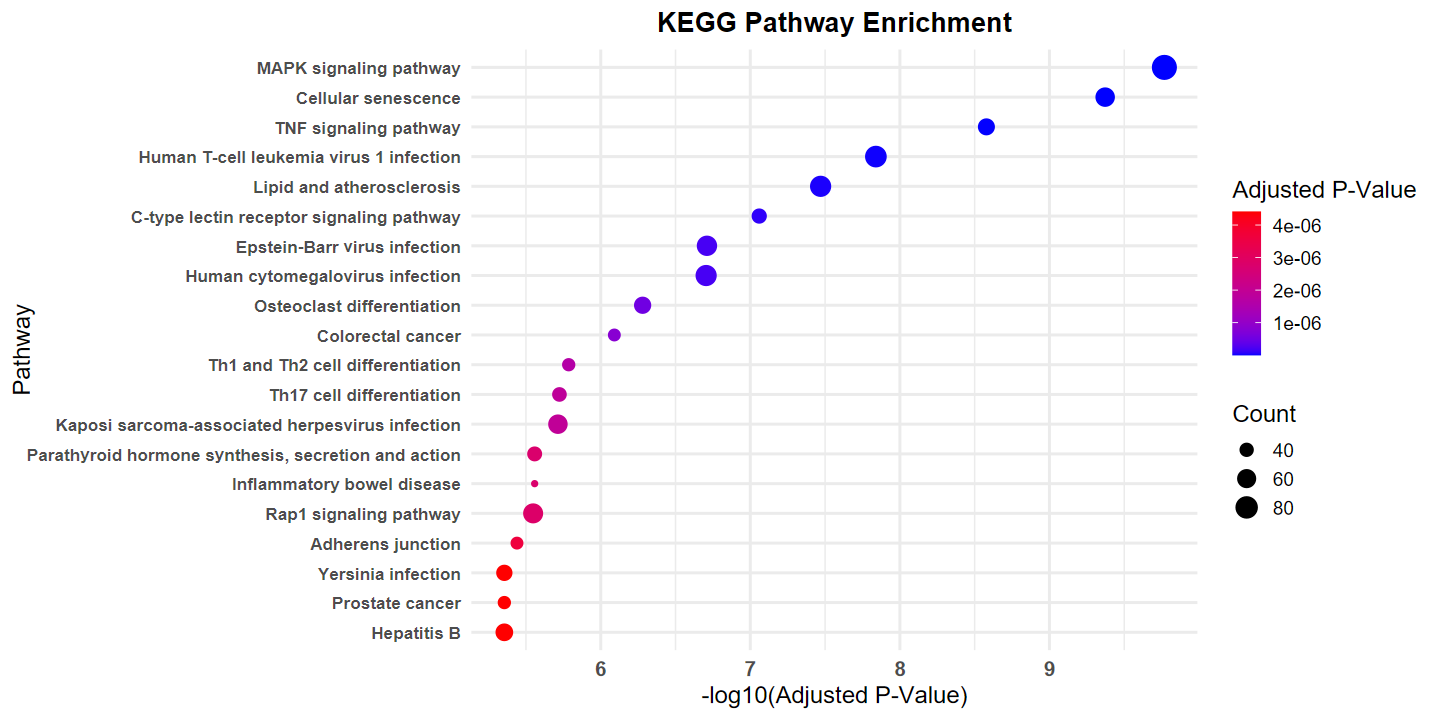

In [ ]:
library(ggplot2)
library(dplyr)

# Prepare KEGG results (convert to data frame and select top 20 pathways)
top_kegg <- kegg_results_df %>%
  arrange(p.adjust) %>%
  slice_head(n = 20)

# Create the dotplot
kegg_dotplot <- ggplot(top_kegg, aes(x = -log10(p.adjust), y = reorder(Description, -log10(p.adjust)), size = Count, color = p.adjust)) +
  geom_point() +
  scale_color_gradient(low = "blue", high = "red", name = "Adjusted P-Value") +
  labs(
    title = "KEGG Pathway Enrichment",
    x = "-log10(Adjusted P-Value)",
    y = "Pathway"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(size = 12, face = "bold"),
    axis.text.y = element_text(size = 10, face = "bold"),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16)
  )

options(repr.plot.width = 12, repr.plot.height = 6) # Adjust plot dimensions in interactive environment
print(kegg_dotplot)

ggsave("results/kegg_PEA.png", plot = kegg_dotplot, width = 10, height = 6, dpi = 300)


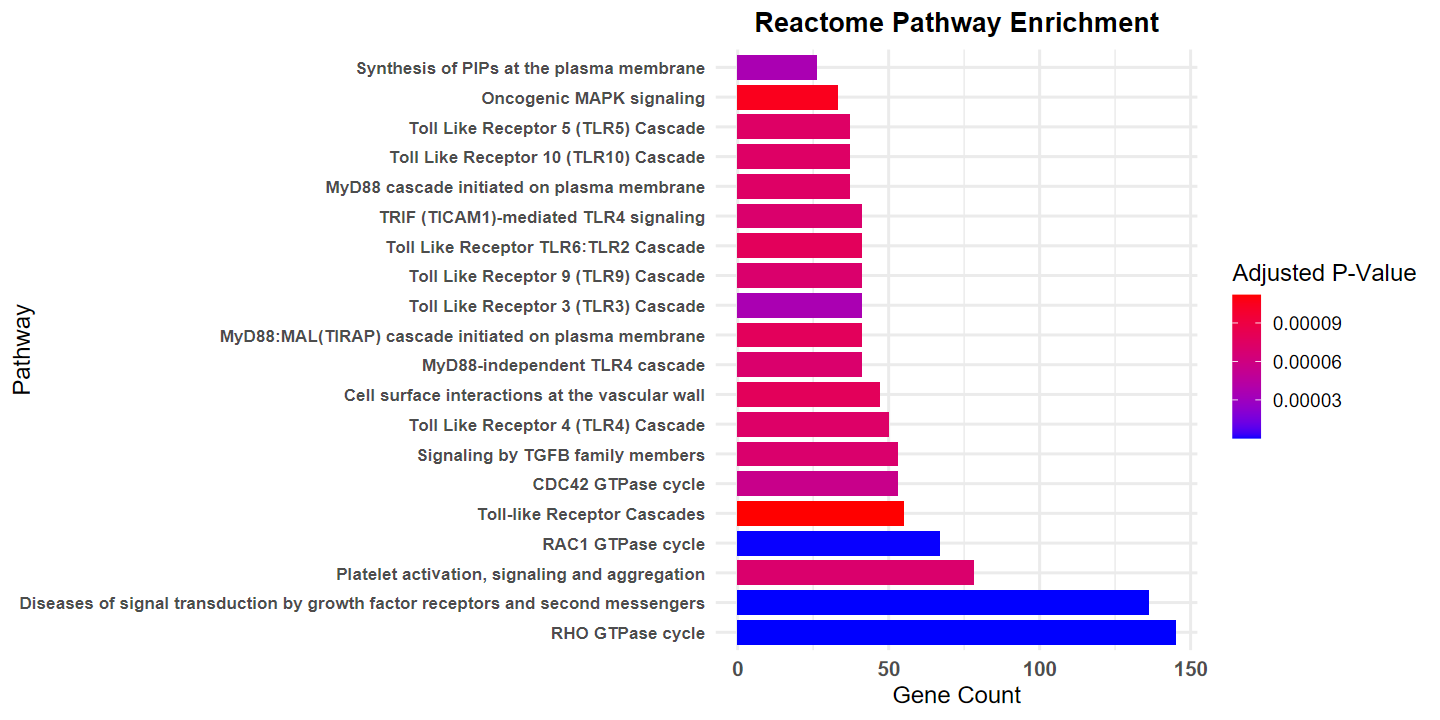

In [ ]:
# Select top 20 pathways based on adjusted p-value
top_reactome <- reactome_results_df %>%
  arrange(p.adjust) %>%
  slice_head(n = 20)

# Create ggplot for Reactome results
reactome_plot <- ggplot(top_reactome, aes(x = reorder(Description, -Count), y = Count, fill = p.adjust)) +
  geom_bar(stat = "identity", width = 0.8) +
  coord_flip() +
  scale_fill_gradient(low = "blue", high = "red", name = "Adjusted P-Value") +
  labs(
    title = "Reactome Pathway Enrichment",
    x = "Pathway",
    y = "Gene Count"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(size = 12, face = "bold"),
    axis.text.y = element_text(size = 10, face = "bold"),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16)
  )

options(repr.plot.width = 12, repr.plot.height = 6) # Adjust plot dimensions in interactive environment

print(reactome_plot)

ggsave("results/reactome_PEA.png", plot = reactome_dotplot, width = 10, height = 6, dpi = 300)


Great! That is a sufficient amount of pathway analysis for now. These plots provide a transcriptomic overview of your cells by highlighting significantly enriched pathways, such as signaling or metabolic processes, based on differentially expressed genes. They help identify key biological processes driving cellular behavior, offering insights into functional roles, regulatory mechanisms, and potential cellular responses.

Finally, we will move into Cell-type annotation. 

## 2.3 Cell Type Annotation 



Using cell type annotation from a published dataset can provide critical insights into characterizing our HSCs behavior on Day 0. By comparing the HSC single-cell RNA-seq profiles to previously annotated datasets, we can assign biological labels to your cells, offering context about their functional roles or states. This approach bridges the gap between raw data and biological interpretation, leveraging prior knowledge about cell types to clarify uncharacterized clusters. 

We will specifically be using  **SingleR()**, which relies on reference samples and marker genes, refines the annotation process, improving accuracy and reducing ambiguity. This enables a more systematic and reliable understanding of cellular behavior in your dataset.

In [ ]:
# Waiting on this action, since CellDex isn't working.


# Step 3: Clustering Day 0 Population 

In this section, we will perform **dimensionality reduction** and **clustering** on the Day 0 RNA-seq data from the hematopoietic stem cell (HSC) population. Dimensionality reduction techniques, such as PCA and UMAP, will be employed to visualize and capture key patterns in the data, while clustering algorithms will identify distinct subpopulations within the Day 0 dataset (although it is my intuition that there should exist none at this point). These approaches will allow us to explore transcriptional heterogeneity, revealing potential functional subsets or biological states of HSCs at this time point.

## 3.1 Dimensionality Reduction 
Dimensionality reduction, such as Principal Component Analysis (PCA), is a critical step in analyzing high-dimensional data like single-cell RNA-seq from HSCs. Each gene represents a dimension in this data, and clustering cells based on their expression profiles requires reducing these dimensions while retaining key biological signals. PCA identifies axes, or principal components (PCs), that capture the largest variance in the dataset, helping to uncover dominant patterns of heterogeneity. The earlier PCs are likely to reflect biological processes as they summarize correlated gene behavior, while later PCs often capture noise. This property makes PCA ideal for denoising and data compaction, improving computational efficiency for clustering and visualization. By focusing on the early PCs, we can highlight meaningful transcriptional patterns in HSCs, reduce noise, and perform downstream analyses with computationally efficient representations of the data.

We will run it below using the `fixedPCA()` function: 

In [ ]:
normal_sce <- fixedPCA(normal_sce, rank = 100, subset.row = hvgs.d0, name = "PCA.1")


Selecting the number of principal components (PCs) to retain for downstream analysis is a critical yet challenging decision when working with the HSC dataset. Retaining more PCs ensures that more biological signal is captured, but it may also introduce noise. Conversely, using fewer PCs risks discarding weaker but biologically relevant signals. Much like the selection of highly variable genes (HVGs), there is no definitive "optimal" number of PCs, as this depends on the biological question being addressed. For instance, variation related to heterogeneity in differentiation potential might be valuable for one analysis but considered noise for another focused solely on distinct cell types.

Most practitioners choose a reasonable range, such as 10–50 PCs, which is sufficient for capturing most of the variance in scRNA-seq datasets. In the HSC dataset, early PCs are expected to represent significant biological patterns, while later PCs likely contribute little meaningful variance and mainly represent noise. A few PCs explain most of the variance, with the inclusion of additional PCs having negligible impact on variance explained. Therefore, selecting a moderate number of PCs ensures that meaningful variation is retained without overburdening computational resources, enabling efficient downstream clustering and visualization of transcriptional states.

We can begin by looking at the Variance Vs. PC plot below, to make a decision on the number of PCA's to include: 

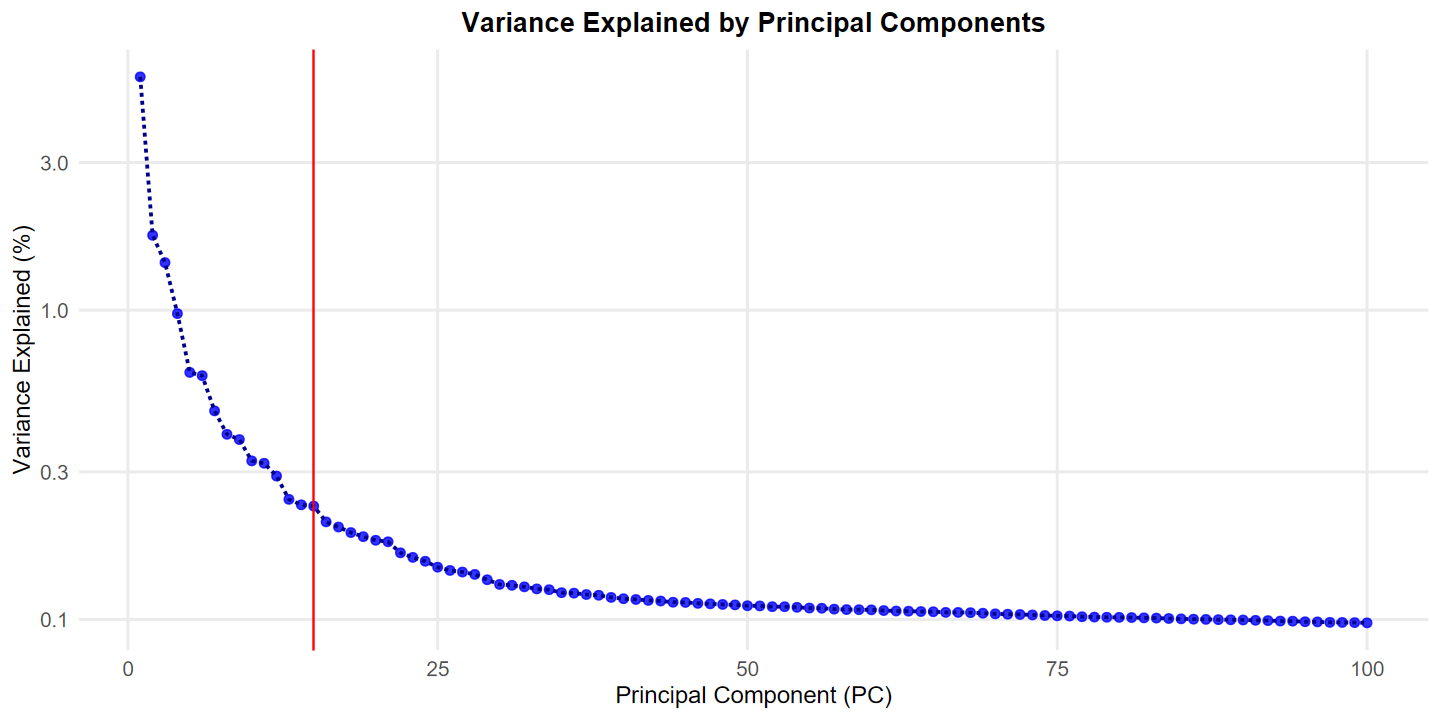

In [ ]:
library(ggplot2)

# Assuming percent.var contains the variance explained
percent_var_df <- data.frame(
  PC = seq_along(percent.var), # PC indices
  Variance = percent.var # Variance explained
)

# Create the ggplot
pca_plot <- ggplot(percent_var_df, aes(x = PC, y = Variance)) +
  geom_point(size = 2, color = "blue", alpha = 0.8) + # Dots for each PC
  geom_line(color = "darkblue", linetype = "dashed", size = 0.8) + # Line connecting points
  scale_y_log10() + # Log10 scale for variance
  labs(
    title = "Variance Explained by Principal Components",
    x = "Principal Component (PC)",
    y = "Variance Explained (%)"
  ) +
  theme_minimal(base_size = 14) + # Minimal theme for clean look
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14),
    panel.grid.minor = element_blank() # Remove minor grid lines
  ) +
  geom_vline(xintercept = 15, colour = "red")

# Print the plot
print(pca_plot)

ggsave("results/PCAplot.png", plot = reactome_dotplot, width = 10, height = 6, dpi = 300)


I determined that 15 principal components (PCs) will be used for downstream analysis based on the elbow method. This approach identifies a point where the variance explained by additional PCs diminishes significantly, making further inclusion less impactful. Beyond 15 PCs, the computational tradeoff outweighs the potential benefit, as additional components primarily capture noise or marginal variance. This selection ensures computational efficiency while retaining the most biologically relevant variation in the data.

We are now ready to continue with our clustering efforts. 

## 3.2 Clustering 

Clustering is an unsupervised learning method used to group cells with similar expression profiles into distinct clusters, simplifying the complexity of scRNA-seq data for interpretation. It enables the identification of population heterogeneity by organizing cells into discrete, interpretable labels, which can serve as proxies for biological concepts like cell types or states. Rather than defining the "true" number of clusters, clustering acts as a tool for exploring data at varying resolutions and perspectives, allowing analysts to experiment with different parameters and algorithms. The value of clustering lies in how well it approximates biologically meaningful states, acknowledging that the optimal resolution depends on the specific research context and questions being addressed.

Lets begin by clustering below: 

In [147]:
set.seed(100)
library(bluster)

normalSce_clusters <- clusterCells(normal_sce, use.dimred = "PCA.1", BLUSPARAM = NNGraphParam(k = 20, cluster.fun = "louvain", type = "jaccard"))

colLabels(normal_sce) <- normal_sce

normal_sce <- runUMAP(normal_sce, dimred = "PCA.1", n_neighbors = 20, name = "UMAP.1")

colLabels(normal_sce) <- normalSce_clusters

plotReducedDim(normal_sce, dimred = "UMAP.1", colour_by = "label")


: 